# A broad overview of linear regression basic functionality

This notebook walks through the basic functionality of the `ya_glm` package for linear regression. Some of this overlaps with existing sklearn functionality in which case we get the same answer. Some of this is not in sklearn e.g. Tikhonov, concave penalties, user specified group Lasso.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

from ya_glm.backends.fista.LinearRegression import Vanilla,\
    Lasso, Ridge, ENet, \
    LassoCV, RidgeCV, ENetCV,\
    AdaptiveLasso, AdaptiveENet,\
    AdaptiveLassoCV, AdaptiveENetCV,\
    FcpLLA, FcpLLACV

# useful functionality for cross-validations
from ya_glm.glm_loss.linear_regression import LinRegScorer
from ya_glm.cv.cv_viz import plot_cv_path

from ya_glm.toy_data import sample_sparse_lin_reg

# Let's make sure our algorithms give the same answer as sklearn
from sklearn.linear_model import LinearRegression as LinRegSklearn
from sklearn.linear_model import Lasso as LassoSklearn
from sklearn.linear_model import Ridge as RidgeSklearn
from sklearn.linear_model import ElasticNet as ENetSklearn

from sklearn.linear_model import LassoCV as LassoCVSklearn
from sklearn.linear_model import RidgeCV as RidgeCVSklearn
from sklearn.linear_model import ElasticNetCV as ElasticNetCVSklearn

Text(0.5, 1.0, 'True coefficient')

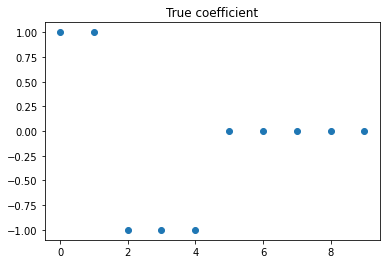

In [2]:
# sample some linear regression data with a sparse coefficient
X, y, coef_true, intercept_true = \
    sample_sparse_lin_reg(n_samples=100, n_features=10, n_nonzero=5,
                          noise_std=1,
                          random_state=234)

plt.scatter(np.arange(len(coef_true)), coef_true)
plt.title("True coefficient")

In [3]:
def print_error(a, b, to=None):
    err = abs(a - b).sum()
    if to is not None:
        print('L1 norm of difference to {}: {:1.6f}'.format(to, err))
    else:
        print('L1 norm of difference: {:1.6f}'.format(err))

# Vanilla linear regression

Let's check we get the same answer as sklearn for basic linear regression

In [4]:
%time est = Vanilla().fit(X, y)

%time est_sk = LinRegSklearn().fit(X, y)

# double check we get the same answer as sklearn!
print_error(est.coef_, est_sk.coef_, to='sklearn')

CPU times: user 13.7 ms, sys: 2.96 ms, total: 16.6 ms
Wall time: 14.5 ms
CPU times: user 926 µs, sys: 203 µs, total: 1.13 ms
Wall time: 1.05 ms
L1 norm of difference to sklearn: 0.000132


# Lasso

Similarly let's check we match sklearn for Lasso

In [5]:
pen_val = 2

%time est = Lasso(pen_val=pen_val).fit(X, y)

%time est_sk = LassoSklearn(alpha=pen_val).fit(X, y)

# double check we get the same answer as sklearn!
print_error(est.coef_, est_sk.coef_, 'sklearn')

CPU times: user 12.2 ms, sys: 2.86 ms, total: 15 ms
Wall time: 12.9 ms
CPU times: user 1.02 ms, sys: 289 µs, total: 1.31 ms
Wall time: 1.28 ms
L1 norm of difference to sklearn: 0.000000


### Lasso with Cross-Validation

Just like in LassoCV we can run cross-validation using a path/homomtopy algorithm to make computing the whole training path very fast!

In [6]:
%time est_sk = LassoCVSklearn(fit_intercept=False).fit(X, y) 

# fits with Lasso homotopy path algorithm

# notice we pass in a Lasso base class into estimator()
# this is how we control the arguments to Lasso e.g. fit_intercept

# also notice we pass in the (optional) LinRegScorer() -- this tracks 
# additional data during cross-validation e.g. the number of non-zero coefficients
est_path = LassoCV(estimator=Lasso(fit_intercept=False),
                   cv_scorer=LinRegScorer())
%time est_path.fit(X, y) # fits with Lasso homotopy path algorithm

CPU times: user 52 ms, sys: 2.71 ms, total: 54.7 ms
Wall time: 53.2 ms
CPU times: user 1.34 s, sys: 33.1 ms, total: 1.37 s
Wall time: 1.47 s


LassoCV(cv_scorer=<ya_glm.glm_loss.linear_regression.LinRegScorer object at 0x7fc22514f810>,
        estimator=Lasso(fit_intercept=False))

In [7]:
# Let's see how far our estimate is from the true coefficient
print_error(est_path.best_estimator_.coef_, coef_true, 'true coefficient')
print_error(est_sk.coef_, coef_true, 'true coefficient')

L1 norm of difference to true coefficient: 0.973099
L1 norm of difference to true coefficient: 0.973033


### Lasso Path visualizations

We include some very basic visualizations for the cross-validation path. For example, we can see the range of number of non-zero coefficients computed along the tuning path. This allows us to double check we fit the entire ``reasonable" range of tuning parameters.

Text(0.5, 1.0, 'Lasso tuning path support size of cv train coef')

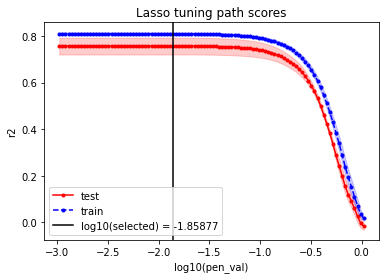

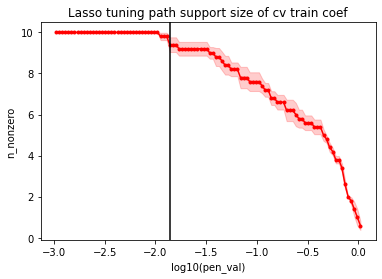

In [8]:
plt.figure()
plot_cv_path(cv_results=est_path.cv_results_,
             param='pen_val', metric='r2',
             log_param=True,
             selected_idx=est_path.best_tune_idx_)
plt.title("Lasso tuning path scores")


plt.figure()
plot_cv_path(cv_results=est_path.cv_results_,
             param='pen_val', metric='n_nonzero',
             log_param=True,
             show_train=False,
             selected_idx=est_path.best_tune_idx_)
plt.title("Lasso tuning path support size of cv train coef")

# Ridge

Ok now let's check ridge regression

In [9]:
pen_val = 2

%time est = Ridge(pen_val=pen_val).fit(X, y)

# sklearn scales the ridge regression loss differently so we need to 
# scale the tuning parameter accordingly
%time est_sk = RidgeSklearn(alpha=X.shape[0] * pen_val).fit(X, y)

# check we get the same answer
print_error(est.coef_, est_sk.coef_)

CPU times: user 13.9 ms, sys: 2.62 ms, total: 16.5 ms
Wall time: 14.6 ms
CPU times: user 633 µs, sys: 110 µs, total: 743 µs
Wall time: 672 µs
L1 norm of difference: 0.000060


### Ridge with CV

Our ridge CV comes with a guess at the reasonable range of tuning parameter values.

In [10]:
# our ridge CV
est = RidgeCV(pen_min_mult=1e-5, cv_scorer=LinRegScorer())
%time est.fit(X, y) 
print_error(est.best_estimator_.coef_, coef_true, 'true coefficient')


# Sklearn's ridge CV
%time est_sk = RidgeCVSklearn().fit(X, y)
print_error(est_sk.coef_, coef_true, 'true coefficient')

CPU times: user 1.04 s, sys: 7.22 ms, total: 1.05 s
Wall time: 1.05 s
L1 norm of difference to true coefficient: 1.092881
CPU times: user 997 µs, sys: 250 µs, total: 1.25 ms
Wall time: 1.08 ms
L1 norm of difference to true coefficient: 0.985951


### Ridge CV visualization

By plotting the L2 norm of the estimated coefficient we can indeed verify that we have tuning over a reasonable range of tuning parameters.

Text(0.5, 1.0, 'Length of coefficient CV-path')

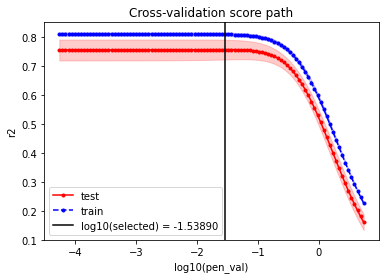

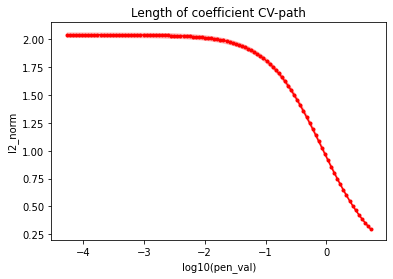

In [11]:
plt.figure()
plot_cv_path(cv_results=est.cv_results_,
             param='pen_val', metric='r2',
             log_param=True,
             selected_idx=est.best_tune_idx_)
plt.title("Cross-validation score path")

plt.figure()
plot_cv_path(cv_results=est.cv_results_,
             param='pen_val', metric='l2_norm',
             show_train=False,
             log_param=True)

plt.title("Length of coefficient CV-path")

# Tikhonov

In [12]:
mat = np.random.normal(size=(X.shape[1], X.shape[1]))
est = Ridge(tikhonov=mat)
est.fit(X, y)

Ridge(tikhonov=array([[ 5.40616942e-01,  1.60691400e+00,  2.33113390e-01,
        -9.69675457e-01,  6.09562828e-01, -1.28583205e+00,
         1.11535577e+00,  6.73311194e-01, -4.60047291e-01,
         2.91872501e-01],
       [ 2.65903623e-01, -7.29546978e-01, -5.42320966e-01,
         1.03347415e+00, -2.05321104e-01, -8.74465092e-01,
        -1.01986567e+00,  1.48215426e+00,  2.28757657e-01,
        -4.34182503e-01],
       [-2.47988344e-0...
        -3.49747352e-01, -8.12059500e-01, -9.49111772e-01,
        -6.75381804e-01],
       [ 5.82257871e-04,  9.92724727e-02, -1.27127995e-01,
        -6.87393928e-01,  6.08660002e-01,  5.30247775e-02,
         4.90476239e-01,  2.08403198e+00,  5.22401761e-01,
         8.92149613e-01],
       [ 1.14854562e-01, -1.45859318e+00, -9.89519987e-01,
         5.79960885e-01,  1.02197965e+00, -7.31811878e-01,
         1.04239947e+00,  1.20777774e+00, -8.36700146e-01,
        -7.83794374e-01]]))

In [13]:
# TODO: tik with CV

# ElasticNet

You probably get the idea by this point, but here is ElasticNet. Our ElasticNetCV tunes over l1_ratio by default. Not very useful here since the desing matrix is fully independent.

In [14]:
pen_val = 2
l1_ratio = 0.5

%time est = ENet(pen_val=pen_val, l1_ratio=l1_ratio).fit(X, y)

%time est_sk = ENetSklearn(alpha=pen_val, l1_ratio=l1_ratio).fit(X, y)

# let's check we get the same answer
print_error(est.coef_, est_sk.coef_)

CPU times: user 13.5 ms, sys: 3.56 ms, total: 17.1 ms
Wall time: 14.3 ms
CPU times: user 948 µs, sys: 183 µs, total: 1.13 ms
Wall time: 1.04 ms
L1 norm of difference: 0.000003


In [15]:
# tunes over a few l1_ratio valeues by default
%time est = ENetCV().fit(X, y) 

# l1 ratio sequence
%time est_sk = ElasticNetCVSklearn().fit(X, y) 

CPU times: user 809 ms, sys: 9.82 ms, total: 819 ms
Wall time: 819 ms
CPU times: user 51.1 ms, sys: 906 µs, total: 52 ms
Wall time: 52 ms


In [16]:
# let's see how far from the truth we are
print_error(est.best_estimator_.coef_, coef_true, 'true coefficient')
print_error(est_sk.coef_, coef_true, 'true coefficient')

L1 norm of difference to true coefficient: 1.019980
L1 norm of difference to true coefficient: 0.973687


# ElasticNet with Tikhonov

In [17]:
# single fit
est = ENet(pen_val=pen_val, l1_ratio=l1_ratio, tikhonov=mat).fit(X, y)

# cross-validation
# notice the penalty arguments are controlled through the estimator
est = ENetCV(estimator=ENet(tikhonov=mat)).fit(X, y) 

# Group Lasso with user specified groups

In [18]:
groups = [np.arange(5), np.arange(5, 10)]

est = Lasso(groups=groups, # specify indices of groups 
            
            # for group lasso this ensures gorups are weighted by 1/sqrt(group_size)
            standardize=True)
%time est.fit(X, y)

CPU times: user 15.5 ms, sys: 2.38 ms, total: 17.9 ms
Wall time: 16.3 ms


Lasso(groups=[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9])], standardize=True)

In [19]:
# note we set the groups using the estimator argument
%time est = LassoCV(estimator=Lasso(groups=groups, standardize=True)).fit(X, y)

CPU times: user 727 ms, sys: 10.8 ms, total: 737 ms
Wall time: 737 ms


# Adaptive Lasso

The Adaptive Lasso takes an initial estimate and makes it better.

In [20]:
init = LassoCV().fit(X, y) # initialize with a Lasso 

est = AdaptiveLasso(init=init)
# est = AdaptiveLasso(init='default') # we provide a LassoCV default initializer
# est = AdaptiveENet()# or elastic net version
# est = Adaptive(groups=groups) # or group version
# est = AdaptiveENet(groups=groups) # or gruop elastic net version
est.fit(X, y)

AdaptiveLasso(init=LassoCV())

In [21]:
# the adaptive lasso comes with a path algorithm to make cross-validation faster
%time est_cv = AdaptiveLassoCV().fit(X, y)

# the above is equivalent to the following call
# since we use LassoCV() as the default initializer
# est = AdaptiveLassoCV(estimator=AdaptiveLasso(init=LassoCV())).fit(X, y)


print_error(est_cv.best_estimator_.coef_, coef_true, 'true coefficient')

CPU times: user 1.5 s, sys: 12 ms, total: 1.51 s
Wall time: 1.52 s
L1 norm of difference to true coefficient: 0.707019


# Folded concave penalty (FCP)

Now let's use a concave penalty instead of a Lasso. We use SCAD by default. This is a two step estimator where we initializer from somewhere (e.g. a vanilla Lasso) then improve our estimate using a concave penalty.

In [22]:
init = LassoCV().fit(X, y) # initialize with a Lasso 
est = FcpLLA(init=init)
# est = FcpLLA(init='default') # we could have just stuck with the default

%time est.fit(X, y)

CPU times: user 10.7 ms, sys: 28 µs, total: 10.7 ms
Wall time: 10.7 ms


FcpLLA(init=LassoCV())

### Cross-validation

In [23]:
# tune with cross-validation
%time est_cv = FcpLLACV().fit(X, y)
print_error(est_cv.best_estimator_.coef_, coef_true, 'true coefficient')

CPU times: user 7.02 s, sys: 55.6 ms, total: 7.08 s
Wall time: 7.13 s
L1 norm of difference to true coefficient: 0.555128


#### Group Lasso with concave penalty

In [24]:
est = FcpLLA(groups=groups)
est_cv = FcpLLACV(estimator=est).fit(X, y)

### FCP with CV

And we can tune the folded concave penalty using cross-validation. Note behind the scences we fit an initializer once, then pass this initializer to each cross-validation fold.

In [25]:
# we have a default tuning parameter range which similarly to how LassoCV picks
# its default tuning parameter sequence
est = FcpLLACV(cv_scorer=LinRegScorer())
%time est.fit(X, y)

CPU times: user 6.98 s, sys: 29.7 ms, total: 7.01 s
Wall time: 7.04 s


FcpLLACV(cv_scorer=<ya_glm.glm_loss.linear_regression.LinRegScorer object at 0x7fc2256c9ad0>)

In [26]:
# now let see how we did compare to our initial estimate
print("Lasso initilizer")
print_error(est.init_est_.best_estimator_.coef_, coef_true, 'true coefficient')

print("FCP estimate")
print_error(est.best_estimator_.coef_, coef_true, 'true coefficient')

Lasso initilizer
L1 norm of difference to true coefficient: 0.958729
FCP estimate
L1 norm of difference to true coefficient: 0.555128


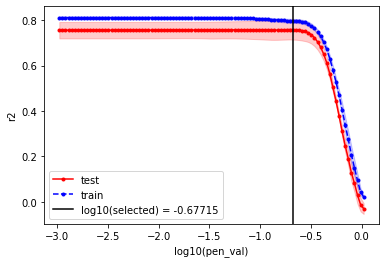

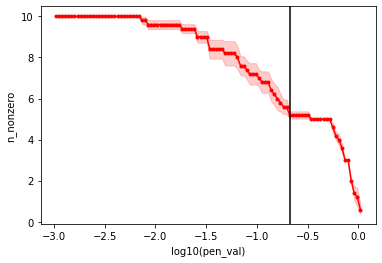

In [27]:
# plotting the tuning path
plt.figure()
plot_cv_path(cv_results=est.cv_results_,
             param='pen_val', metric='r2',
             log_param=True,
             selected_idx=est.best_tune_idx_)


plt.figure()
plot_cv_path(cv_results=est.cv_results_,
             param='pen_val', metric='n_nonzero',
             log_param=True,
             show_train=False,
             selected_idx=est.best_tune_idx_)